In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# import libraries
import torch
import torchvision
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
from torchvision import datasets
from skimage import io, transform
from torch.utils.data import DataLoader
import time
import os
#from tensorboardcolab import TensorBoardColab
from PIL import Image
from torchvision import transforms
import logging
from datetime import datetime

# Get the seconds since epoch
secondsSinceEpoch = time.time()
# Convert seconds since epoch to struct_time
timeObj = time.localtime(secondsSinceEpoch)

time = str(timeObj.tm_mday)+ '-' + str(timeObj.tm_mon) +'-'+ str(timeObj.tm_year)+'-'+str(timeObj.tm_hour)+'_'+str(timeObj.tm_min)
print(time)

# Path of Folders
content = '/content/drive/My Drive/new-frames/'
labels_csv = '/content/drive/My Drive/weights.csv'
train_path = content + "train"
test_path = content + "test"
validation_path = content + "validation"

weights=pd.read_csv(labels_csv)
weights = weights['WEIGHT'].values

print('Start initialization logging file')
logging.basicConfig(filename='app_' + time + '.log', filemode='w', format='%(name)s - %(levelname)s - %(message)s')
logging.warning('Initialized File')



6-4-2020-14_37
Start initialization logging file


In [0]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.2):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        return torch.cat([x, out], 1)

class BottleneckBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(BottleneckBlock, self).__init__()
        inter_planes = out_planes * 4
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, inter_planes, kernel_size=1, stride=1,
                               padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(inter_planes)
        self.conv2 = nn.Conv2d(inter_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        out = self.conv2(self.relu(self.bn2(out)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        return torch.cat([x, out], 1)

class TransitionBlock(nn.Module):
    def __init__(self, in_planes, out_planes, dropRate=0.0):
        super(TransitionBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1,
                               padding=0, bias=False)
        self.droprate = dropRate
    def forward(self, x):
        out = self.conv1(self.relu(self.bn1(x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, inplace=False, training=self.training)
        return F.avg_pool2d(out, 2)

class DenseBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, growth_rate, block, dropRate=0.0):
        super(DenseBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, growth_rate, nb_layers, dropRate)
    def _make_layer(self, block, in_planes, growth_rate, nb_layers, dropRate):
        layers = []
        for i in range(nb_layers):
            layers.append(block(in_planes+i*growth_rate, growth_rate, dropRate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)

class DenseNetFixed(nn.Module):
    def __init__(self, depth, num_classes, growth_rate=12,
                 reduction=0.5, bottleneck=True, dropRate=0.0):
        super(DenseNetFixed, self).__init__()
        in_planes = 2 * growth_rate
        n = (depth - 4) / 3
        if bottleneck == True:
            n = n/2
            block = BottleneckBlock
        else:
            block = BasicBlock
        n = int(n)
        # 1st conv before any dense block
        self.conv1 = nn.Conv2d(1, in_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+n*growth_rate)
        self.trans1 = TransitionBlock(in_planes, int(math.floor(in_planes*reduction)), dropRate=dropRate)
        in_planes = int(math.floor(in_planes*reduction))
        # 2nd block
        self.block2 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+n*growth_rate)
        self.trans2 = TransitionBlock(in_planes, int(math.floor(in_planes*reduction)), dropRate=dropRate)
        in_planes = int(math.floor(in_planes*reduction))
        # 3rd block
        self.block3 = DenseBlock(n, in_planes, growth_rate, block, dropRate)
        in_planes = int(in_planes+n*growth_rate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(96, num_classes)
        self.fc2 = nn.Linear(1, 1)
        self.in_planes = in_planes

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.block1(out))
        out = self.trans2(self.block2(out))
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        #print('Before pool.', out.shape)
        out = F.avg_pool2d(out, 8)
        #print('After pool.', out.shape)

        #out = out.view(-1, self.in_planes)
        out = out.view(out.size(0), -1) 

        #print('Linear.', out.shape)

        out = self.fc(out)
        #print('Linear1.', out.shape)
        
        out = out.view(out.size(0), -1) 
        out = self.fc2(out)
        #print('Linear2.', out.shape)
        return out

 

In [0]:
def train(net,data_loader,optimizer,cost_function, device='cuda'):
  samples = 0.
  cumulative_loss = 0.
  #cumulative_accuracy = 0.
  
  # Set the network in train mode
  net.train()
  logging.info('Start Training')
  
  # Loop over the dataset
  for batch_idx, (inputs, targets) in enumerate(data_loader):
    # Load data into GPU
    inputs = inputs.to(device)
    
    targets = targets.to(device)
    #print("\t\t targets:" , len(targets))
    
    # Forward pass
    outputs = net(inputs)

    # Apply the loss
    loss = cost_function(outputs, targets)

    lambda_ = torch.tensor(1.).to(device)
    l2_reg = torch.tensor(0.).to(device)
    for param in net.parameters():
      l2_reg += torch.norm(param)
    loss += lambda_ * l2_reg
    #loss.backward() 

    
    loss.backward()
    
    # Update parameters
    optimizer.step()
    
    # Reset the optimizer
    optimizer.zero_grad()
    logging.warning('\t\t\tBatch Train {:.5f} Loss: {:.5f} -- IN-Shape{:.5f}'.format(batch_idx, loss.item() / inputs.shape[0], inputs.shape[0]))
    #print('\t\t\tBatch Train {:.5f} Loss: {:.5f} -- IN-Shape{:.5f}'.format(batch_idx, loss.item() / inputs.shape[0], inputs.shape[0]))

    samples+=inputs.shape[0]
    cumulative_loss += loss.item()
  #print('Samples',samples)
  return cumulative_loss/samples


def test(net, data_loader, cost_function, device='cuda'):
  samples = 0.
  cumulative_loss = 0.
  #cumulative_accuracy = 0.

  logging.info('Start Testing/Validation')


  #Set the network in eval mode
  net.eval()
  with torch.no_grad(): # torch.no_grad() disables the autograd machinery, thus not saving the intermediate activations
    # Loop over the dataset
    for batch_idx, (inputs, targets) in enumerate(data_loader):
      # Load data into GPU
      inputs = inputs.to(device)

      targets = targets.to(device)
      targets = targets.view(-1,1)

      # Forward pass
      outputs = net(inputs)

      # Apply the loss
      loss = cost_function(outputs, targets)

      # Better print something
      samples+=inputs.shape[0]
      cumulative_loss += loss.item() # Note: the .item() is needed to extract scalars from tensors
      
      logging.warning('\t\t\tBatch Train {:.5f} Loss: {:.5f} -- IN-Shape{:.5f}'.format(batch_idx, loss.item() / inputs.shape[0], inputs.shape[0]))

      #_, predicted = outputs
      #print("Predicted:", outputs.size())
      #cumulative_accuracy += predicted.eq(targets).sum().item()

  return cumulative_loss/samples



def get_optimizer(net, lr, wd, momentum):
  optimizer = torch.optim.Adam(net.parameters(), lr=lr)#, betas=(0.9, 0.999), eps=1e-08, amsgrad=False)
  return optimizer

def get_cost_function():
  cost_function = torch.nn.MSELoss()
  return cost_function

In [4]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split

weights=pd.read_csv(labels_csv)
train_IDs, test_IDs = train_test_split(weights, test_size=0.30, random_state=42)

# Check len of IDs
print('Train:', len(train_IDs))
print('Test:', len(test_IDs))


def generateDatasetIDS(list, root_folder = "/content/drive/My Drive/frames/"):
  """
  Return a list with all the image paths relative to those IDs
  """
  test_list = []
  for id in list:
    #print("Id:", id)
    for root, dirs, files in os.walk(root_folder + str(id) ):
        for filename in files:
            #print("\t", str(id) + "/" + filename)
            if('.png' in filename):
              add_file = str(id) + "/" + filename
              test_list.append(add_file)
  return test_list


class CustomListDataset(torch.utils.data.Dataset):

    def __init__(self, images_list, df_weights, root_dir,transform = None):
        """
        Args:
            images_list(list): list with IDs into the dataset
            root_dir(string): directory with all the images
            df_weights(pd_dataframe): dataframe with all the weights of the people
            transform: trasform operation for images
        """
        self.images_list = images_list
        self.root_dir = root_dir
        self.df_weights = df_weights
        self.df_weights = self.df_weights['WEIGHT'].values
        self.transform = transform

    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images_list[idx])
        image = Image.open(img_name)
        #image = image.convert(mode='RGB')
        
        if(self.transform is not None):
            image = self.transform(image)

        frame_name = self.images_list[idx].split("/")
        id = int(frame_name[0])
        
        labels = self.df_weights[id]
        labels = np.float(labels)
        #print(labels)
        #sample = {'image': image, 'labels': labels}
        return image, torch.as_tensor(labels)

        #return sample


transform = transforms.Compose([
    # you can add other transformations in this list
    #transforms.Resize((299,299), interpolation=2),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(20),
    transforms.ToTensor()
])

#testDataset = CustomListDataset(images_list = test_list, df_weights = weights,root_dir="/content/drive/My Drive/frames/", transform = transform)
#mnistmTrainLoader = torch.utils.data.DataLoader(testDataset,batch_size=16,shuffle=True, num_workers=2)

Train: 72
Test: 31


In [0]:
model = DenseNetFixed(depth = 5, num_classes = 1)
checkpoint = torch.load("/content/drive/My Drive/model/1channel.pt")
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [0]:
test_list = generateDatasetIDS(test_IDs.ID,"/content/drive/My Drive/frames/")
print(len(test_list))
test_custom = CustomListDataset(images_list = test_list, df_weights = weights, root_dir="/content/drive/My Drive/frames/", transform = transform)
test_final_loader = torch.utils.data.DataLoader(test_custom, batch_size=32, shuffle=False, num_workers=2)

print(len(test_final_loader))
print(len(test_final_loader.dataset))


991
31
991


In [0]:
x,y=test_custom.__getitem__(0)
print(x.shape, y)

torch.Size([1, 150, 150]) tensor(71.)


In [0]:
#test_IDs

model.cuda()
loss_fn = get_cost_function()

print('After training:')
#train_loss = test(net, train_loader, cost_function)
test_loss = test(model, test_final_loader, loss_fn)

#print('\t Training loss {:.5f}'.format(train_loss))
print('\t Test loss {:.5f},'.format(test_loss))
print('-----------------------------------------------------')

After training:
	 Test loss 2.94461,
-----------------------------------------------------


In [0]:
device='cuda:0'
model.to(device)
predicted_label = list()
real_label = list()

#Set the network in eval mode
model.eval()
with torch.no_grad():
  # Loop over the dataset
  for batch_idx, (inputs, targets) in enumerate(test_final_loader):
    # Load data into GPU
    inputs = inputs.to(device)
    print('inputs', inputs.shape)

    targets = targets.to(device)
    print('targets', targets.shape)

    # Forward pass
    outputs = model.forward(inputs)
    
    print('Out:',outputs.shape)
    

    arr1 = outputs.data.cpu().numpy()
    #predicted_label += arr1
    arr2 = targets.data.cpu().numpy()
    #real_label += arr2


    predicted_label.extend(arr1)
    real_label.extend(arr2)


inputs torch.Size([32, 1, 150, 150])
targets torch.Size([32])
Out: torch.Size([32, 1])
inputs torch.Size([32, 1, 150, 150])
targets torch.Size([32])
Out: torch.Size([32, 1])
inputs torch.Size([32, 1, 150, 150])
targets torch.Size([32])
Out: torch.Size([32, 1])
inputs torch.Size([32, 1, 150, 150])
targets torch.Size([32])
Out: torch.Size([32, 1])
inputs torch.Size([32, 1, 150, 150])
targets torch.Size([32])
Out: torch.Size([32, 1])
inputs torch.Size([32, 1, 150, 150])
targets torch.Size([32])
Out: torch.Size([32, 1])
inputs torch.Size([32, 1, 150, 150])
targets torch.Size([32])
Out: torch.Size([32, 1])
inputs torch.Size([32, 1, 150, 150])
targets torch.Size([32])
Out: torch.Size([32, 1])
inputs torch.Size([32, 1, 150, 150])
targets torch.Size([32])
Out: torch.Size([32, 1])
inputs torch.Size([32, 1, 150, 150])
targets torch.Size([32])
Out: torch.Size([32, 1])
inputs torch.Size([32, 1, 150, 150])
targets torch.Size([32])
Out: torch.Size([32, 1])
inputs torch.Size([32, 1, 150, 150])
target

In [0]:
len(predicted_label)

991

In [0]:
#print (predicted_label)

import numpy as np
predicted_label = np.array(predicted_label,dtype=int)
real_label = np.array(real_label, dtype=int)
#print(predicted_label)

pred_label_list = list()
for x in np.nditer(predicted_label):
  #print(x)
  pred_label_list.append(x)

real_label_list = list()
for x in np.nditer(real_label):
  real_label_list.append(x)

print(len(pred_label_list))

991


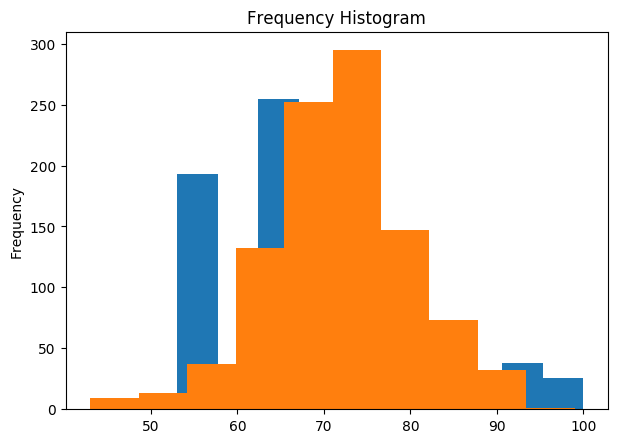

In [0]:
from statistics import mean 

#target_mean_baseline = mean(real_label_list)
#print(target_mean_baseline)

#Plot the distribution of the test labels

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Plot Histogram on x
#x = np.random.normal(size = 1000)
plt.hist(real_label_list)
plt.hist(pred_label_list)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

Text(0, 0.5, 'Predicted')

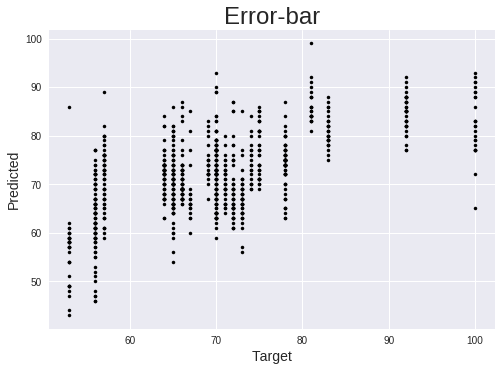

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import numpy as np

plt.errorbar(real_label_list, pred_label_list,  fmt='.k');
plt.title('Error-bar',fontsize=24)
plt.xlabel('Target',fontsize=14)
plt.ylabel('Predicted',fontsize=14)

From the error bar it is possible to see that the predictions over the test frames have a distribution around the real value. 
The following task is to see the distribution of some test values wrt some real values:

<class 'numpy.ndarray'>


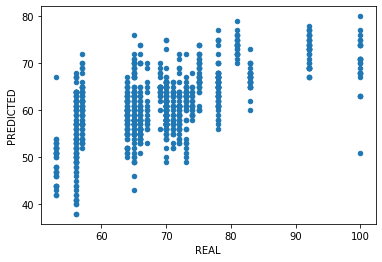

In [0]:
import numpy as np
import pandas as pd

'''real_label, predicted_label'''

print(type(real_label))

df = pd.DataFrame({'REAL': np.asarray(real_label_list), 'PREDICTED':np.asarray(pred_label_list)})
df.plot('REAL', 'PREDICTED', kind='scatter')

In [0]:
#See unique real values 
print(df.PREDICTED.unique())

#Check the average value of the predicted labels
df.groupby('REAL').mean()

[52 59 60 62 65 61 63 64 57 55 58 56 66 53 74 72 71 75 77 73 76 79 70 67
 68 69 78 54 50 51 44 46 47 43 48 42 49 80 45 40 41 38]


,PREDICTED
REAL,
53,49.314286
56,54.767677
57,60.762712
64,58.764706
65,60.450000
66,58.911765
67,60.368421
69,64.652174
70,60.302158


In [0]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error

def r2_rmse( g ):
    r2 = r2_score( g.REAL, g.PREDICTED)
    count = len(g.REAL)
    mse = mean_squared_error( g['REAL'], g['PREDICTED'] ) 
    rmse = np.sqrt( mean_squared_error( g['REAL'], g['PREDICTED'] ) ) 
    return pd.Series( dict( count = int(count), r2 = r2, rmse = rmse, mse = mse ) )

print("Global:", r2_rmse(df))

#Statistics over REAL value
df.groupby( 'REAL' ).apply( r2_rmse ).reset_index()

Global: count    991.000000
r2        -0.257937
rmse      11.368562
mse      129.244198
dtype: float64


,REAL,count,r2,rmse,mse
0,53,35.0,0.0,5.954590,35.457143
1,56,99.0,0.0,7.538454,56.828283
2,57,59.0,0.0,6.019742,36.237288
3,64,68.0,0.0,6.633250,44.000000
4,65,100.0,0.0,7.598026,57.730000
5,66,68.0,0.0,8.815094,77.705882
6,67,19.0,0.0,7.986831,63.789474
7,69,23.0,0.0,5.200334,27.043478
8,70,139.0,0.0,10.529165,110.863309
9,71,35.0,0.0,12.278902,150.771429


69.39253279515641
991
Global: count    991.000000
r2         0.000000
rmse      10.136222
mse      102.742992
dtype: float64


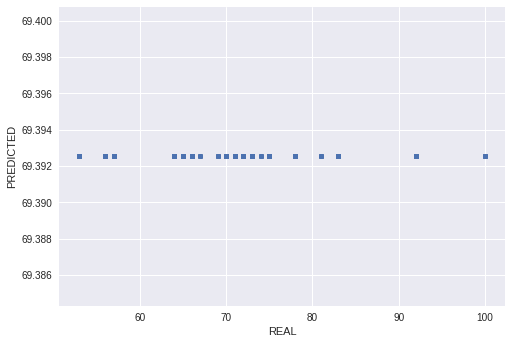

In [0]:
#Global distribution of the error - TARGET MATCHING
average = df["REAL"].mean()

print(average)
average_list = np.repeat(average, len(real_label_list))

print(len(real_label_list))

dfMatch = pd.DataFrame({'REAL': np.asarray(real_label_list), 'PREDICTED':np.asarray(average_list)})
dfMatch.plot('REAL', 'PREDICTED', kind='scatter')


print("Global:", r2_rmse(dfMatch))